# 라이브러리 임포트

In [ ]:
import os, tqdm, math, random

import numpy as np
import pandas as pd

from glob import glob
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm


# CUDA 설정

In [ ]:
torch.manual_seed(777)

In [ ]:
torch.cuda.manual_seed_all(777)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


# 데이터 전처리

torch.Size([28, 28])


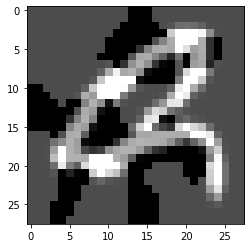

In [ ]:
import matplotlib.cm as cm
idx = 710
print(test_dataset[idx][0].shape)
print(test_dataset[idx][1])
plt.imshow(test_dataset[idx][0], cmap=cm.gray)

# DAE dataset

In [ ]:
def add_noise(img):
    noise = torch.randn(img.size())*0.2
    noisy_img = img+noise
    return noisy_img

In [ ]:
dae_train = torchvision.datasets.EMNIST(
    root='./emnist', split='letters', train=True, download=True, 
)

In [ ]:
#dae dataset
class dae_dataset(Dataset):
    def __init__(self, dataset, transform=False):
        self.data = dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize((0.1307,), (0.3081,))
        ])
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx][0]
        data = self.transform(data)
        target = add_noise(data)
        
        return data, target

In [ ]:
dae_dataset = dae_dataset(dae_train)

In [ ]:
dae_loader = DataLoader(dae_dataset, batch_size=32, shuffle=True, num_workers=8)

# classify dataset

In [ ]:
train_data = np.load('./amcl-test/emnist_train.npz')
test_data = np.load('./amcl-test/emnist_test.npz')

In [ ]:
# classify dataset
class Customdataset(Dataset):
    def __init__(self, dataset, transform=False):
        self.data = dataset['data']
        self.target = dataset['target'].astype('int64')

        
        self.transform = transforms.Compose([
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = torch.Tensor(self.data[idx])
        data = self.transform(data)
        target = self.target[idx]
        
        return data, target

In [ ]:
class Testdataset(Dataset):
    def __init__(self, dataset, transform=False):
        self.data = dataset['data']
        self.transform = transforms.Compose([
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = torch.Tensor(self.data[idx])
        data = self.transform(data)
        
        return data

In [ ]:
#dae_dataset = dae_dataset(val['data'], train['data'])
train_dataset = Customdataset(train_data)
test_dataset = Testdataset(test_data)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

# 모델

## DAE

In [ ]:
class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 8, 5, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 7, 1, 1),
            nn.BatchNorm2d(16),
        )
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 7, 1, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 5, 2, 1, 1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x=self.Encoder(x)
        x=self.Decoder(x)
        
        return x

## resnet 18

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride):
        super(BasicBlock, self).__init__()

        norm_layer = nn.BatchNorm2d

        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1)
        self.bn1 = norm_layer(out_channel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 =  nn.Conv2d(out_channel, out_channel, 3, stride=1, padding=1)
        self.bn2 = norm_layer(out_channel)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 1, stride=2),
            nn.BatchNorm2d(out_channel)
        )
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.stride==2:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Resnet18(nn.Module):
    def __init__(self, num_classe=10):
        super(Resnet18, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, 7, 2, 3), # 14*14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1) # 7*7
        )
        
        self.layer2 = nn.Sequential(
            BasicBlock(64, 64, 1),
            BasicBlock(64, 64, 1)
        )   
        self.layer3 = nn.Sequential(
            BasicBlock(64, 128, 2), # 4*4
            BasicBlock(128, 128, 1)
        )   
        self.layer4 = nn.Sequential(
            BasicBlock(128, 256, 2),
            BasicBlock(256, 256, 1)
        )   
        self.layer5 = nn.Sequential(
            BasicBlock(256, 512, 2),
            BasicBlock(512, 512, 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.avgpool = nn.AvgPool2d((1, 1))
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## simple cnn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 80, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(80)
        self.conv5 = nn.Conv2d(80, 96, 3, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 112, 3, bias=False)     # output becomes 16x16
        self.conv6_bn = nn.BatchNorm2d(112)
        self.conv7 = nn.Conv2d(112, 128, 3, bias=False)    # output becomes 14x14
        self.conv7_bn = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 144, 3, bias=False)    # output becomes 12x12
        self.conv8_bn = nn.BatchNorm2d(144)
        self.conv9 = nn.Conv2d(144, 160, 3, bias=False)    # output becomes 10x10
        self.conv9_bn = nn.BatchNorm2d(160)
        self.conv10 = nn.Conv2d(160, 176, 3, bias=False)   # output becomes 8x8
        self.conv10_bn = nn.BatchNorm2d(176)
        self.fc1 = nn.Linear(11264, 128, bias=False)
        self.fc1_bn = nn.BatchNorm1d(128)
        
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv7 = F.relu(self.conv7_bn(self.conv7(conv6)))
        conv8 = F.relu(self.conv8_bn(self.conv8(conv7)))
        conv9 = F.relu(self.conv9_bn(self.conv9(conv8)))
        conv10 = F.relu(self.conv10_bn(self.conv10(conv9)))
        flat1 = torch.flatten(conv10.permute(0, 2, 3, 1), 1)
        out = self.fc1_bn(self.fc1(flat1))
        return out

In [ ]:
class ModelM5(nn.Module):
    def __init__(self):
        super(ModelM5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, bias=False)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, bias=False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 96, 5, bias=False)
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(96, 128, 5, bias=False)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 160, 5, bias=False)
        self.conv5_bn = nn.BatchNorm2d(160)
        self.fc1 = nn.Linear(10240, 128, bias=False)
        self.fc1_bn = nn.BatchNorm1d(128)
        
        
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        flat5 = torch.flatten(conv5.permute(0, 2, 3, 1), 1)
        out = self.fc1_bn(self.fc1(flat5))
        
        return out

In [ ]:

class ModelM7(nn.Module):
    def __init__(self):
        super(ModelM7, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, 7, bias=False)    # output becomes 22x22
        self.conv1_bn = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(48, 96, 7, bias=False)   # output becomes 16x16
        self.conv2_bn = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 144, 7, bias=False)  # output becomes 10x10
        self.conv3_bn = nn.BatchNorm2d(144)
        self.conv4 = nn.Conv2d(144, 192, 7, bias=False) # output becomes 4x4
        self.conv4_bn = nn.BatchNorm2d(192)
        self.fc1 = nn.Linear(3072, 128, bias=False)
        self.fc1_bn = nn.BatchNorm1d(128)
        
    def forward(self, x):    
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        flat1 = torch.flatten(conv4.permute(0, 2, 3, 1), 1)
        out = self.fc1_bn(self.fc1(flat1))
        return out
    

## 앙상블 모델

In [ ]:
class Model(nn.Module):
    def __init__(self, dae, resnet, simple):
        super(Model, self).__init__()
        
        #self.dae = dae
        self.resnet = resnet
        self.simple = simple
        
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 26),
            nn.BatchNorm1d(26),
            nn.ReLU(),
            
        )
        
    def forward(self, x):
        #out = self.dae(x)
        out_resnet = self.resnet(x)
        out_simple = self.simple(x)
        
        out = out_resnet + out_simple
        
        out = self.fc(out)
        
        return out

In [ ]:
class Model2(nn.Module):
    def __init__(self, model1, model2, model3):
        super(Model2, self).__init__()
        
        #self.dae = dae
        self.model = model1
        self.model2 = model2
        self.model3 = model3
        
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 26),
            nn.BatchNorm1d(26),
            nn.ReLU(),
            
        )
        
    
        
    def forward(self, x):
        out1 = self.model(x)
        out2 = self.model2(x)
        out3 = self.model3(x)
        
        out = out1 + out2 + out3
        
        out = self.fc(out)
        
        return out

In [ ]:
class Model3(nn.Module):
    def __init__(self, train=False):
        super(Model3, self).__init__()
        
        #self.dae = dae
        self.model = torchvision.models.resnet18(pretrained=train)
        self.model2 = torchvision.models.mobilenet_v2(pretrained=train)
        self.model3 = torchvision.models.squeezenet1_1(pretrained=train)
        
        self.model2.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=1280, out_features=26, bias=True)
        )
        self.model2.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        
        self.model.fc = nn.Linear(in_features=512, out_features=26, bias=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        self.model3.classifier[1] = nn.Conv2d(512, 26, kernel_size=(1, 1), stride=(1, 1))
        self.model3.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
        
    def forward(self, x):
        out1 = self.model(x)
        out2 = self.model2(x)
        out3 = self.model3(x)
        
        out = out1 + out2 + out3
        
        return out

# 학습

## train_dae

In [ ]:
criterion = nn.MSELoss().to(device)
dae = DAE()
dae = dae.to(device)

opt = torch.optim.Adam([param for param in dae.parameters() if param.requires_grad], lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size = 10, gamma = 0.8) 

In [ ]:
train_loss = []
for epoch in range(50):
    dae.train()

    loss_ = 0
    
    epoch_loss = 0

    for batch, train in tqdm(enumerate(dae_loader), total=len(dae_loader)):
        data, label = train
        
        data = data.to(device)
        
        label = label.to(device)

        out = dae(data)

        loss = criterion(out, label)

        loss_ += loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()

        
    epoch_loss = loss_ / len(dae_loader.dataset)
    
    train_loss.append(epoch_loss)
    
    print(f'epoch : {epoch+1}\t Loss : {epoch_loss:.10f}')
    
    scheduler.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:45<00:00, 85.36it/s]

epoch : 1	 Loss : 0.0019292094



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:43<00:00, 88.82it/s]

epoch : 2	 Loss : 0.0013109477



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:45<00:00, 85.06it/s]

epoch : 3	 Loss : 0.0012819253



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:43<00:00, 89.17it/s]

epoch : 4	 Loss : 0.0012769362



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:43<00:00, 90.49it/s]

epoch : 5	 Loss : 0.0012747456



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:46<00:00, 84.36it/s]

epoch : 6	 Loss : 0.0012733084



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:44<00:00, 87.27it/s]

epoch : 7	 Loss : 0.0012721149



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:46<00:00, 84.60it/s]

epoch : 8	 Loss : 0.0012706575



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:45<00:00, 85.42it/s]

epoch : 9	 Loss : 0.0012693718



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:46<00:00, 84.26it/s]

epoch : 10	 Loss : 0.0012688984



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:44<00:00, 87.77it/s]

epoch : 11	 Loss : 0.0012679184



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:44<00:00, 86.97it/s]

epoch : 12	 Loss : 0.0012676198



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:44<00:00, 88.15it/s]

epoch : 13	 Loss : 0.0012670093



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:43<00:00, 89.34it/s]

epoch : 14	 Loss : 0.0012669313



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:45<00:00, 86.01it/s]

epoch : 15	 Loss : 0.0012663242



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:45<00:00, 86.31it/s]

epoch : 16	 Loss : 0.0012655953



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:45<00:00, 84.96it/s]

epoch : 17	 Loss : 0.0012651594



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:45<00:00, 85.80it/s]

epoch : 18	 Loss : 0.0012650422



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:44<00:00, 87.03it/s]

epoch : 19	 Loss : 0.0012643090



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:44<00:00, 87.14it/s]

epoch : 20	 Loss : 0.0012640382



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:43<00:00, 89.36it/s]

epoch : 21	 Loss : 0.0012637045



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:44<00:00, 87.24it/s]

epoch : 22	 Loss : 0.0012632176



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:44<00:00, 87.49it/s]

epoch : 23	 Loss : 0.0012633256



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:44<00:00, 88.33it/s]

epoch : 24	 Loss : 0.0012634170



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:42<00:00, 92.72it/s]

epoch : 25	 Loss : 0.0012629398



100%|████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:43<00:00, 89.50it/s]

epoch : 26	 Loss : 0.0012627518



 58%|███████████████████████████████████████████████▊                                   | 2244/3900 [00:22<00:16, 101.01it/s]


KeyboardInterrupt: 

## resnet train

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
resnet = Resnet18()
resnet = resnet.to(device)

opt = torch.optim.Adam([param for param in resnet.parameters() if param.requires_grad], lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size = 10, gamma = 0.8) 

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    with torch.no_grad():

        val_loss = 0
        correct = 0

        for batch_idx, sample in enumerate(val_loader):
            data, label = sample
            data = data.to(cuda)
            label = label.to(cuda)

            output = model(data)
            loss = criterion(output, label)
            val_loss += loss.item()

            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = (100. * correct) / len(test_loader.dataset)


        return val_loss, val_acc

In [ ]:
# label값을 tensor로 바꾼후 model을 예측을 max로 바꾼후 loss 계산
from tqdm import tqdm

train_loss = []

train_acc = []

val_loss = []

val_acc = []


for epoch in range(50):
    resnet.train()

    cost = 0
    
    epoch_loss = 0
    
    acc = 0
    
    epoch_acc = 0
    
    eval_acc = 0
    
    eval_loss = 0

    for batch, train in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, label = train
        
        data = data.to(device)
        
        label = label.to(device)
        
        opt.zero_grad()
        
        out = resnet(data)
        
        loss = criterion(out, label)
        
        pred = out
        
        pred = pred.max(dim=1, keepdim=True)[1]
        
        cost += loss.item()
        
        acc += pred.eq(label.view_as(pred)).sum().item()
        
        loss.backward()
        opt.step()
        

        
    epoch_loss = cost / len(train_loader.dataset)
    
    epoch_acc = (acc / len(train_loader.dataset)) * 100.
    
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)


    print(f'epoch : {epoch+1}\t Loss : {epoch_loss:.6f}\t acc : {epoch_acc:.6f}')
    

    scheduler.step()

 25%|█████████████████████▋                                                               | 478/1875 [00:18<00:53, 26.00it/s]


KeyboardInterrupt: 

In [ ]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():

        val_loss = 0
        correct = 0

        for batch_idx, sample in tqdm(enumerate(test_loader), total=len(test_loader0)):
            data, label = sample
            data = data.to(cuda)

            output = model(data)
            loss = criterion(output, label)
            val_loss += loss.item()

            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

        val_loss /= len(test_loader.dataset)
        val_acc = (100. * correct) / len(test_loader.dataset)


        return val_loss, val_acc

In [ ]:
evaluate(resnet, val_loader)

(0.08835403752525647, 56.065)

## simple cnn train

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
simple = ModelM3()
simple = simple.to(device)

opt = torch.optim.Adam([param for param in simple.parameters() if param.requires_grad], lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size = 10, gamma = 0.8) 

In [ ]:
# label값을 tensor로 바꾼후 model을 예측을 max로 바꾼후 loss 계산
from tqdm import tqdm

train_loss = []

train_acc = []

val_loss = []

val_acc = []


for epoch in range(50):
    simple.train()

    cost = 0
    
    epoch_loss = 0
    
    acc = 0
    
    epoch_acc = 0
    
    eval_acc = 0
    
    eval_loss = 0

    for batch, train in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, label = train
        
        data = data.to(device)
        
        label = label.to(device)
        
        opt.zero_grad()
        
        out = simple(data)
        
        loss = criterion(out, label)
        
        pred = out
        
        pred = pred.max(dim=1, keepdim=True)[1]
        
        cost += loss.item()
        
        acc += pred.eq(label.view_as(pred)).sum().item()
        
        loss.backward()
        opt.step()
        

        
    epoch_loss = cost / len(train_loader.dataset)
    
    epoch_acc = (acc / len(train_loader.dataset)) * 100.
    
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
#     eval_acc, eval_loss = evaluate(resnet, val_dataset)
    
#     val_loss.append(eval_loss)
#     val_acc.append(eval_acc)


    print(f'epoch : {epoch+1}\t Loss : {epoch_loss:.6f}\t acc : {epoch_acc:.6f}')
    

    scheduler.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 44.28it/s]

epoch : 1	 Loss : 0.020353	 acc : 87.681667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:43<00:00, 43.38it/s]

epoch : 2	 Loss : 0.007338	 acc : 96.118333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:43<00:00, 43.19it/s]

epoch : 3	 Loss : 0.004378	 acc : 97.770000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:45<00:00, 41.46it/s]

epoch : 4	 Loss : 0.002817	 acc : 98.533333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 43.83it/s]

epoch : 5	 Loss : 0.001965	 acc : 98.966667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:36<00:00, 51.70it/s]

epoch : 6	 Loss : 0.001545	 acc : 99.125000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:38<00:00, 48.28it/s]

epoch : 7	 Loss : 0.001059	 acc : 99.428333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:39<00:00, 47.56it/s]

epoch : 8	 Loss : 0.000915	 acc : 99.466667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 44.21it/s]

epoch : 9	 Loss : 0.000719	 acc : 99.593333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:34<00:00, 54.50it/s]

epoch : 10	 Loss : 0.000563	 acc : 99.675000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:38<00:00, 48.80it/s]

epoch : 11	 Loss : 0.000371	 acc : 99.826667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:43<00:00, 43.48it/s]


epoch : 12	 Loss : 0.000294	 acc : 99.858333


100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:45<00:00, 41.41it/s]

epoch : 13	 Loss : 0.000355	 acc : 99.771667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:37<00:00, 49.97it/s]

epoch : 14	 Loss : 0.000228	 acc : 99.901667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:40<00:00, 45.92it/s]

epoch : 15	 Loss : 0.000285	 acc : 99.830000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:41<00:00, 45.46it/s]

epoch : 16	 Loss : 0.000202	 acc : 99.888333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:43<00:00, 42.80it/s]

epoch : 17	 Loss : 0.000183	 acc : 99.910000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 44.31it/s]

epoch : 18	 Loss : 0.000197	 acc : 99.888333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:41<00:00, 44.93it/s]

epoch : 19	 Loss : 0.000168	 acc : 99.920000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:44<00:00, 41.97it/s]

epoch : 20	 Loss : 0.000187	 acc : 99.893333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:43<00:00, 43.06it/s]

epoch : 21	 Loss : 0.000106	 acc : 99.936667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 43.88it/s]

epoch : 22	 Loss : 0.000085	 acc : 99.963333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:39<00:00, 47.01it/s]

epoch : 23	 Loss : 0.000123	 acc : 99.915000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:40<00:00, 46.24it/s]

epoch : 24	 Loss : 0.000078	 acc : 99.966667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:40<00:00, 46.65it/s]

epoch : 25	 Loss : 0.000072	 acc : 99.971667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:40<00:00, 46.52it/s]

epoch : 26	 Loss : 0.000069	 acc : 99.966667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:36<00:00, 50.88it/s]

epoch : 27	 Loss : 0.000105	 acc : 99.938333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:44<00:00, 42.37it/s]

epoch : 28	 Loss : 0.000049	 acc : 99.985000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:39<00:00, 47.66it/s]

epoch : 29	 Loss : 0.000069	 acc : 99.963333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:38<00:00, 48.81it/s]

epoch : 30	 Loss : 0.000071	 acc : 99.966667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 44.42it/s]

epoch : 31	 Loss : 0.000047	 acc : 99.981667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 43.92it/s]

epoch : 32	 Loss : 0.000034	 acc : 99.986667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:44<00:00, 42.57it/s]

epoch : 33	 Loss : 0.000059	 acc : 99.968333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:43<00:00, 43.08it/s]

epoch : 34	 Loss : 0.000049	 acc : 99.975000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:37<00:00, 49.85it/s]

epoch : 35	 Loss : 0.000026	 acc : 99.998333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:35<00:00, 52.74it/s]

epoch : 36	 Loss : 0.000041	 acc : 99.976667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:40<00:00, 46.43it/s]

epoch : 37	 Loss : 0.000041	 acc : 99.980000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:43<00:00, 43.23it/s]

epoch : 38	 Loss : 0.000057	 acc : 99.971667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:43<00:00, 42.82it/s]

epoch : 39	 Loss : 0.000020	 acc : 99.993333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 43.76it/s]

epoch : 40	 Loss : 0.000032	 acc : 99.988333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 44.36it/s]

epoch : 41	 Loss : 0.000026	 acc : 99.990000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:43<00:00, 43.30it/s]

epoch : 42	 Loss : 0.000016	 acc : 99.995000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:39<00:00, 46.91it/s]

epoch : 43	 Loss : 0.000018	 acc : 99.995000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:41<00:00, 44.69it/s]

epoch : 44	 Loss : 0.000015	 acc : 99.993333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:39<00:00, 47.30it/s]

epoch : 45	 Loss : 0.000036	 acc : 99.973333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:40<00:00, 46.02it/s]

epoch : 46	 Loss : 0.000009	 acc : 100.000000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:40<00:00, 46.87it/s]

epoch : 47	 Loss : 0.000013	 acc : 99.991667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:42<00:00, 44.48it/s]

epoch : 48	 Loss : 0.000015	 acc : 100.000000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:44<00:00, 41.78it/s]

epoch : 49	 Loss : 0.000026	 acc : 99.983333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:38<00:00, 48.57it/s]

epoch : 50	 Loss : 0.000022	 acc : 99.985000


In [ ]:
torch.save(simple, './model/result/simple.pt')

# 앙상블 모델 학습

In [ ]:
simple = torch.load('./model/result/simple.pt')

In [ ]:
resnet = torch.load('./model/result/resnet18.pt')

In [ ]:
dae = torch.load('./model/result/dae.pt')

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)

model1 = ModelM3()
model2 = ModelM5()
model3 = ModelM7()


model = Model2(model1, model2, model3)
model = model.to(device)

opt = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size = 10, gamma = 0.8) 

In [ ]:
# label값을 tensor로 바꾼후 model을 예측을 max로 바꾼후 loss 계산
from tqdm import tqdm

train_loss = []

train_acc = []




for epoch in range(100):
    model.train()

    cost = 0
    
    epoch_loss = 0
    
    acc = 0
    
    epoch_acc = 0
    

    for batch, train in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, label = train
        
        data = data.to(device)
        
        label = label.to(device)
        
        opt.zero_grad()
        
        out = model(data)
        
        loss = criterion(out, label)
        
        pred = out
        
        pred = pred.max(dim=1, keepdim=True)[1]
        
        cost += loss.item()
        
        acc += pred.eq(label.view_as(pred)).sum().item()
        
        loss.backward()
        opt.step()
        

        
    epoch_loss = cost / len(train_loader.dataset)
    
    epoch_acc = (acc / len(train_loader.dataset)) * 100.
    
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)


    print(f'epoch : {epoch+1}\t Loss : {epoch_loss:.6f}\t acc : {epoch_acc:.6f}')
    

    scheduler.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.89it/s]

epoch : 1	 Loss : 0.021004	 acc : 81.728333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.04it/s]

epoch : 2	 Loss : 0.005075	 acc : 95.638333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.05it/s]

epoch : 3	 Loss : 0.003366	 acc : 97.056667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.53it/s]

epoch : 4	 Loss : 0.002595	 acc : 97.726667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.71it/s]

epoch : 5	 Loss : 0.002010	 acc : 98.208333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.94it/s]

epoch : 6	 Loss : 0.001661	 acc : 98.481667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:03<00:00, 29.33it/s]

epoch : 7	 Loss : 0.001351	 acc : 98.795000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.83it/s]

epoch : 8	 Loss : 0.001069	 acc : 99.041667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:12<00:00, 26.01it/s]

epoch : 9	 Loss : 0.000955	 acc : 99.083333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.52it/s]

epoch : 10	 Loss : 0.000843	 acc : 99.273333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 26.96it/s]

epoch : 11	 Loss : 0.000414	 acc : 99.621667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.75it/s]

epoch : 12	 Loss : 0.000550	 acc : 99.470000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.42it/s]

epoch : 13	 Loss : 0.000445	 acc : 99.600000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.49it/s]

epoch : 14	 Loss : 0.000403	 acc : 99.618333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.54it/s]

epoch : 15	 Loss : 0.000376	 acc : 99.635000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 27.10it/s]

epoch : 16	 Loss : 0.000376	 acc : 99.633333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.35it/s]

epoch : 17	 Loss : 0.000310	 acc : 99.708333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:11<00:00, 26.26it/s]

epoch : 18	 Loss : 0.000284	 acc : 99.736667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.15it/s]

epoch : 19	 Loss : 0.000283	 acc : 99.743333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.13it/s]

epoch : 20	 Loss : 0.000287	 acc : 99.725000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.86it/s]

epoch : 21	 Loss : 0.000181	 acc : 99.826667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:04<00:00, 28.89it/s]

epoch : 22	 Loss : 0.000181	 acc : 99.843333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.20it/s]

epoch : 23	 Loss : 0.000166	 acc : 99.840000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 27.15it/s]

epoch : 24	 Loss : 0.000154	 acc : 99.846667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.48it/s]

epoch : 25	 Loss : 0.000131	 acc : 99.883333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.97it/s]

epoch : 26	 Loss : 0.000171	 acc : 99.845000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.63it/s]

epoch : 27	 Loss : 0.000167	 acc : 99.845000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.74it/s]

epoch : 28	 Loss : 0.000110	 acc : 99.910000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:04<00:00, 29.14it/s]

epoch : 29	 Loss : 0.000150	 acc : 99.863333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 27.15it/s]

epoch : 30	 Loss : 0.000117	 acc : 99.876667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 26.98it/s]

epoch : 31	 Loss : 0.000087	 acc : 99.915000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 26.79it/s]

epoch : 32	 Loss : 0.000119	 acc : 99.886667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 27.02it/s]

epoch : 33	 Loss : 0.000077	 acc : 99.936667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.00it/s]

epoch : 34	 Loss : 0.000121	 acc : 99.911667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.29it/s]

epoch : 35	 Loss : 0.000054	 acc : 99.958333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.23it/s]

epoch : 36	 Loss : 0.000106	 acc : 99.886667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.07it/s]

epoch : 37	 Loss : 0.000069	 acc : 99.931667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 27.13it/s]

epoch : 38	 Loss : 0.000075	 acc : 99.915000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.32it/s]

epoch : 39	 Loss : 0.000069	 acc : 99.943333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 26.94it/s]

epoch : 40	 Loss : 0.000100	 acc : 99.923333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.88it/s]

epoch : 41	 Loss : 0.000048	 acc : 99.968333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.32it/s]

epoch : 42	 Loss : 0.000048	 acc : 99.961667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.45it/s]

epoch : 43	 Loss : 0.000045	 acc : 99.958333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.77it/s]

epoch : 44	 Loss : 0.000039	 acc : 99.961667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:13<00:00, 25.67it/s]

epoch : 45	 Loss : 0.000063	 acc : 99.948333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.35it/s]

epoch : 46	 Loss : 0.000054	 acc : 99.941667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.14it/s]

epoch : 47	 Loss : 0.000029	 acc : 99.975000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.34it/s]

epoch : 48	 Loss : 0.000052	 acc : 99.946667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 27.99it/s]

epoch : 49	 Loss : 0.000048	 acc : 99.956667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.90it/s]

epoch : 50	 Loss : 0.000024	 acc : 99.981667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.48it/s]

epoch : 51	 Loss : 0.000024	 acc : 99.975000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.45it/s]

epoch : 52	 Loss : 0.000032	 acc : 99.976667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:04<00:00, 29.11it/s]

epoch : 53	 Loss : 0.000027	 acc : 99.975000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.47it/s]

epoch : 54	 Loss : 0.000026	 acc : 99.981667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.58it/s]

epoch : 55	 Loss : 0.000032	 acc : 99.973333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.05it/s]

epoch : 56	 Loss : 0.000034	 acc : 99.965000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.18it/s]

epoch : 57	 Loss : 0.000022	 acc : 99.981667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.31it/s]

epoch : 58	 Loss : 0.000024	 acc : 99.981667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.06it/s]

epoch : 59	 Loss : 0.000034	 acc : 99.971667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.93it/s]

epoch : 60	 Loss : 0.000033	 acc : 99.973333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.13it/s]

epoch : 61	 Loss : 0.000014	 acc : 99.991667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.72it/s]

epoch : 62	 Loss : 0.000011	 acc : 99.991667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.11it/s]

epoch : 63	 Loss : 0.000012	 acc : 99.986667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.18it/s]

epoch : 64	 Loss : 0.000010	 acc : 99.988333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.14it/s]

epoch : 65	 Loss : 0.000015	 acc : 99.985000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.98it/s]

epoch : 66	 Loss : 0.000012	 acc : 99.990000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 26.85it/s]


epoch : 67	 Loss : 0.000018	 acc : 99.985000


100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.46it/s]

epoch : 68	 Loss : 0.000022	 acc : 99.976667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.44it/s]

epoch : 69	 Loss : 0.000007	 acc : 99.995000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 27.06it/s]

epoch : 70	 Loss : 0.000019	 acc : 99.978333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.81it/s]

epoch : 71	 Loss : 0.000014	 acc : 99.986667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.57it/s]

epoch : 72	 Loss : 0.000012	 acc : 99.990000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:02<00:00, 29.81it/s]


epoch : 73	 Loss : 0.000005	 acc : 99.996667


100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.59it/s]

epoch : 74	 Loss : 0.000013	 acc : 99.991667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.85it/s]

epoch : 75	 Loss : 0.000010	 acc : 99.993333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.49it/s]

epoch : 76	 Loss : 0.000004	 acc : 100.000000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.66it/s]

epoch : 77	 Loss : 0.000023	 acc : 99.980000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 26.82it/s]

epoch : 78	 Loss : 0.000012	 acc : 99.986667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 26.91it/s]

epoch : 79	 Loss : 0.000006	 acc : 99.995000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.19it/s]

epoch : 80	 Loss : 0.000009	 acc : 99.991667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.98it/s]

epoch : 81	 Loss : 0.000004	 acc : 100.000000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:04<00:00, 29.07it/s]

epoch : 82	 Loss : 0.000007	 acc : 99.996667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.53it/s]

epoch : 83	 Loss : 0.000006	 acc : 99.996667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.45it/s]

epoch : 84	 Loss : 0.000015	 acc : 99.991667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.34it/s]

epoch : 85	 Loss : 0.000005	 acc : 99.996667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.44it/s]

epoch : 86	 Loss : 0.000003	 acc : 100.000000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:11<00:00, 26.27it/s]

epoch : 87	 Loss : 0.000007	 acc : 99.991667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.53it/s]

epoch : 88	 Loss : 0.000004	 acc : 99.996667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.71it/s]

epoch : 89	 Loss : 0.000007	 acc : 99.993333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.30it/s]

epoch : 90	 Loss : 0.000007	 acc : 99.996667



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.68it/s]

epoch : 91	 Loss : 0.000004	 acc : 99.995000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.74it/s]

epoch : 92	 Loss : 0.000003	 acc : 99.998333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.69it/s]

epoch : 93	 Loss : 0.000002	 acc : 99.998333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.73it/s]

epoch : 94	 Loss : 0.000003	 acc : 99.998333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:05<00:00, 28.59it/s]

epoch : 95	 Loss : 0.000004	 acc : 99.998333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.56it/s]

epoch : 96	 Loss : 0.000001	 acc : 100.000000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 26.88it/s]

epoch : 97	 Loss : 0.000002	 acc : 100.000000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:07<00:00, 27.87it/s]

epoch : 98	 Loss : 0.000007	 acc : 99.993333



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:08<00:00, 27.45it/s]

epoch : 99	 Loss : 0.000008	 acc : 99.990000



100%|████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:09<00:00, 27.14it/s]

epoch : 100	 Loss : 0.000003	 acc : 99.996667


In [ ]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():

        val_loss = 0
        correct = 0

        for batch_idx, sample in tqdm(enumerate(test_loader), total=len(test_loader0)):
            data, label = sample
            data = data.to(cuda)

            output = model(data)
            loss = criterion(output, label)
            val_loss += loss.item()

            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

        val_loss /= len(test_loader.dataset)
        val_acc = (100. * correct) / len(test_loader.dataset)


        return val_loss, val_acc


In [ ]:
evaluate(model, val_loader)

(7.853079674167323e-05, 99.91833333333334)

# 저장

In [ ]:
def submission(model, test_loader):
    prediction = np.array([], dtype='uint8')
    model.eval()
    with torch.no_grad():

        for batch_idx, sample in enumerate(test_loader):
            data = sample
            data = data.to(device)

            output = model(data)
            
            out = output.max(1, keepdim=True)[1].cpu().numpy()
            out = np.reshape(out, out.shape[0])
            prediction = np.hstack((prediction, out))
        
        pred = prediction.reshape(20800, 1)
        submission = pd.DataFrame(pred, columns=['Category'])
        submission.index.name = 'Id'

        submission.to_csv('./submission/submission_0228_5.csv')

In [ ]:
submission(model, test_loader)

In [ ]:
torch.save(model, './model/result/dae_resnet18_submission_emnist.pt')

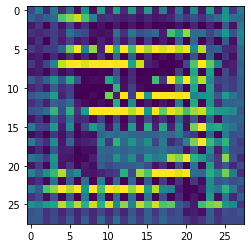

In [ ]:
a = train_dataset[418][0]
a = a.reshape(1, 1, 28, 28).to(device)
model.eval()
out = dae(a)
plt.imshow(out.to('cpu').detach().numpy().squeeze())